In [18]:
import pandas as pd

# Load the datasets
collisions = 'C:/Users/loma5202/OneDrive - Kruvelab/PhD/courses/introduction_to_data_science/project/UK_road_casualty_collision_1979_2022.csv'
vehicles = 'C:/Users/loma5202/OneDrive - Kruvelab/PhD/courses/introduction_to_data_science/project/UK_road_casualty_vehicle_1979_2022.csv'

# Read the CSV files
collisions_data = pd.read_csv(collisions)
vehicles_data = pd.read_csv(vehicles)

C:\Users\loma5202\AppData\Local\Temp\ipykernel_3412\1714511162.py:8: DtypeWarning: Columns (0,2,15,16,35) have mixed types. Specify dtype option on import or set low_memory=False.
C:\Users\loma5202\AppData\Local\Temp\ipykernel_3412\1714511162.py:9: DtypeWarning: Columns (0,2,24,27) have mixed types. Specify dtype option on import or set low_memory=False.


In [19]:
# Remove unnecessary columns
cols_remove = ['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 'police_force',
               'local_authority_district', 'local_authority_ons_district', 'local_authority_highway',
               'first_road_number', 'second_road_number', 'pedestrian_crossing_human_control',
               'trunk_road_flag', 'lsoa_of_accident_location']

cols_save = ['accident_index', 'accident_year', 'accident_reference', 'vehicle_reference', 'vehicle_type',
             'sex_of_driver', 'age_of_driver', 'engine_capacity_cc', 'age_of_vehicle']

collisions_data = collisions_data.drop(cols_remove, axis = 1)
vehicles_data = vehicles_data[cols_save]

In [20]:
# Joining the datasets on 'accident_index'
road_acc_data = pd.merge(collisions_data, vehicles_data, on = 'accident_index', how = 'inner')

In [21]:
road_acc_data.head(1)

,accident_index,accident_year_x,accident_reference_x,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,...,urban_or_rural_area,did_police_officer_attend_scene_of_accident,accident_year_y,accident_reference_y,vehicle_reference,vehicle_type,sex_of_driver,age_of_driver,engine_capacity_cc,age_of_vehicle
0,197901A11AD14,1979,01A11AD14,3,2,1,18/01/1979,5,08:00,3,...,-1,-1,1979,01A11AD14,1,109,1,44,-1,-1


In [23]:
# Remove unnecessary columns from combined data frame
cols_remove = ['accident_reference_x', 'accident_reference_y', 'accident_year_y', 'vehicle_reference']

road_acc_data = road_acc_data.drop(cols_remove, axis = 1)
road_acc_data.rename(columns = {'accident_year_x': 'accident_year'}, inplace = True)

In [27]:
# Re-classifying vehicle_type (all motorcycles in one group, cars + taxi in one group, etc.)
# Creating a mapping function for the vehicle_type groups
def map_vehicle_type(value):
    if value in [2, 3, 4, 5, 97, 104, 105, 106]: # All motorcycle versions (independent of cc)
        return 2
    elif value in [8, 9, 108, 109]: # Cars, taxis and private hire cars
        return 8
    elif value in [20, 21, 113]: # All goods over 3.5 tonnes in one group
        return 20
    elif value in [-1, 90, 98, 99]: # All unknown/other vehicles in one group
        return 90
    elif value in [10, 110]: # Minibuses
        return 10
    else:
        return value

# Applying the mapping function to the vehicle_type column
road_acc_data['vehicle_type_grouped'] = road_acc_data['vehicle_type'].apply(map_vehicle_type)

# Checking the modification by displaying the first few rows
road_acc_data[['vehicle_type', 'vehicle_type_grouped']].head(10)


,vehicle_type,vehicle_type_grouped
0,109,8
1,104,2
2,109,8
3,109,8
4,109,8
5,109,8
6,109,8
7,109,8
8,109,8
9,109,8


In [29]:
# Save the combined dataframe to avoid having to redo the first pre-processing steps every time
road_acc_data.to_csv('C:/Users/loma5202/OneDrive - Kruvelab/PhD/courses/introduction_to_data_science/project/combined_collision_vehicle_1979_2022.csv', index = False)

**If restarting, can start from here**

In [3]:
import pandas as pd

road_acc_data = pd.read_csv('C:/Users/loma5202/OneDrive - Kruvelab/PhD/courses/introduction_to_data_science/project/combined_collision_vehicle_1979_2022.csv')

**Accidents/casualties vs type of vehicle**

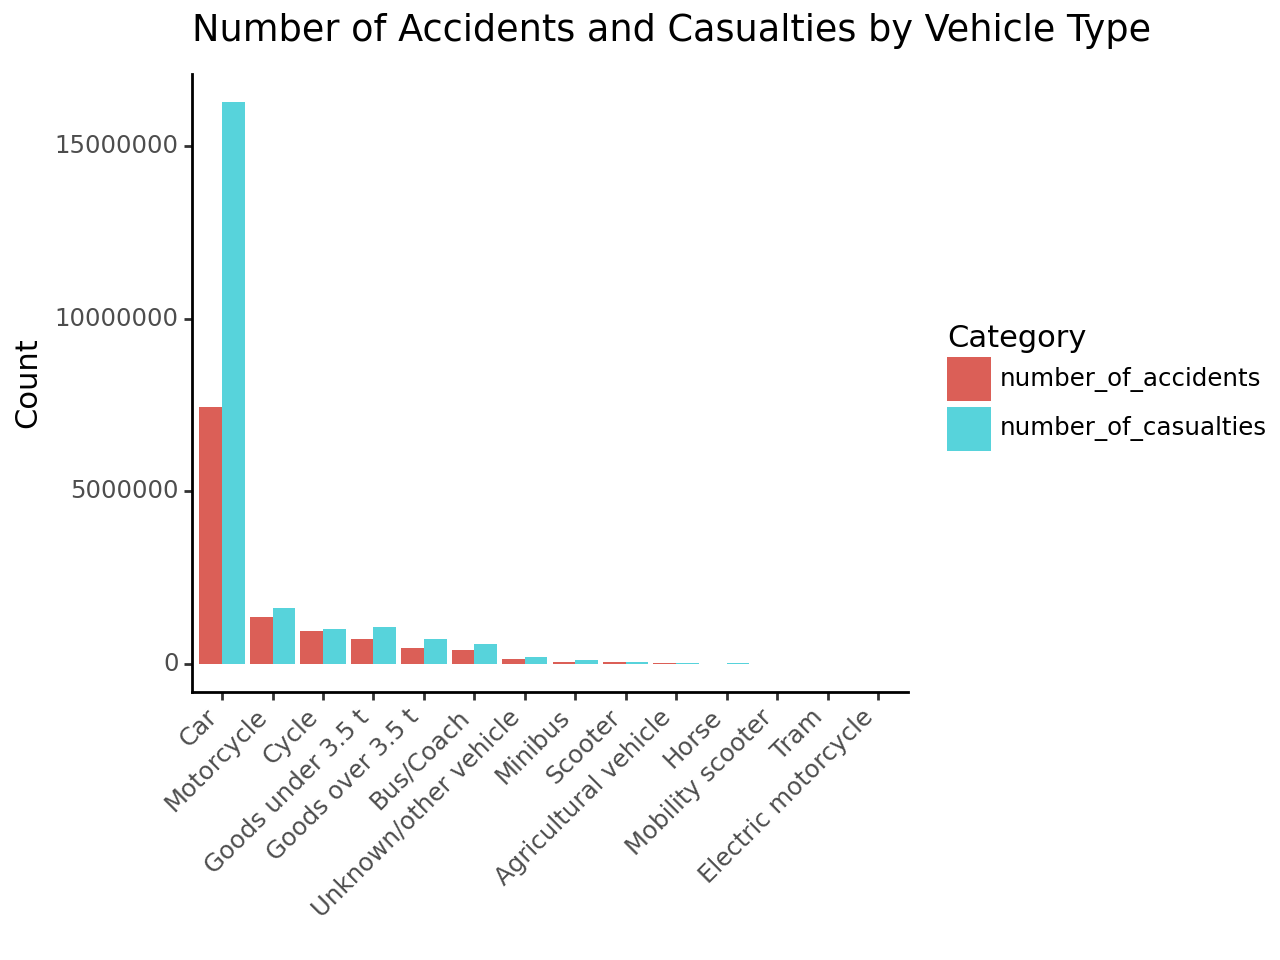

<Figure Size: (640 x 480)>

In [37]:
from plotnine import *

# Count unique accidents and sum casualties for each vehicle type
df_plot_vehicle_type = road_acc_data.groupby('vehicle_type_grouped').agg({'accident_index': pd.Series.nunique, 
                                                       'number_of_casualties': 'sum'}).reset_index()

# Rename columns for clarity
df_plot_vehicle_type.columns = ['vehicle_type_grouped', 'number_of_accidents', 'number_of_casualties']

# Mapping the 'vehicle_type_grouped' values to names, including -1 as 'Unknown/other vehicle'
vehicle_type_mapping = {
    1: "Cycle", 2: "Motorcycle", 8: "Car", 10: "Minibus", 11: "Bus/Coach",
    16: "Horse", 17: "Agricultural vehicle", 18: "Tram", 19: "Goods under 3.5 t",
    20: "Goods over 3.5 t", 22: "Mobility scooter", 23: "Electric motorcycle",
    90: "Unknown/other vehicle", 103: "Scooter"
}

df_plot_vehicle_type['vehicle_type_grouped'] = df_plot_vehicle_type['vehicle_type_grouped'].map(vehicle_type_mapping)

# Melting the DataFrame for use in plotnine
df_plot_vehicle_type = df_plot_vehicle_type.melt(id_vars='vehicle_type_grouped', var_name='Category', value_name='Count')

# Creating the plot
vehicle_type_plot = (
    ggplot(df_plot_vehicle_type, aes(x='reorder(vehicle_type_grouped, -Count)', y='Count', fill='Category')) +
    geom_bar(stat='identity', position='dodge') +
    labs(x='', y='Count', title='Number of Accidents and Casualties by Vehicle Type') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
vehicle_type_plot

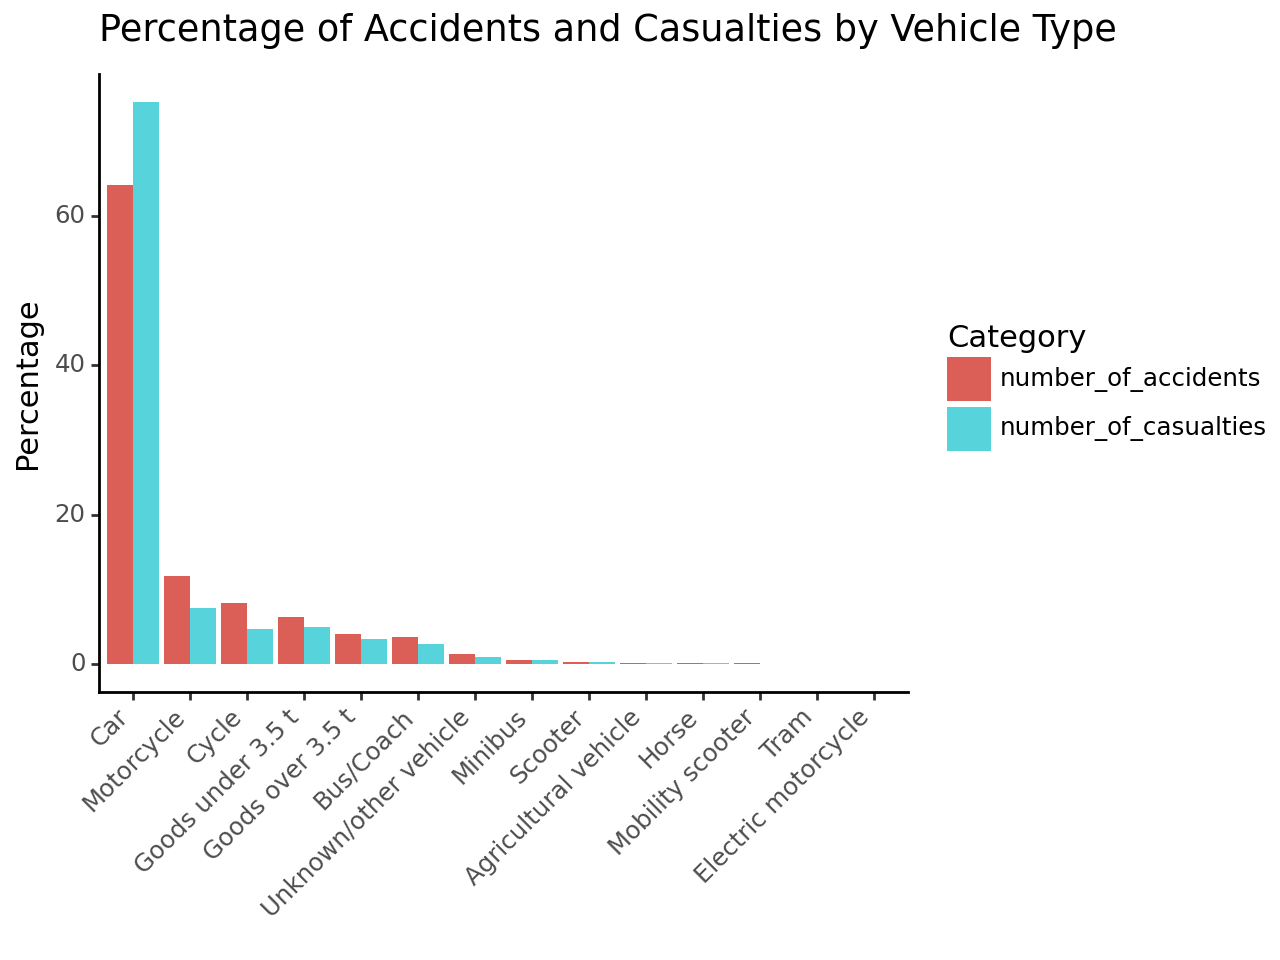

<Figure Size: (640 x 480)>

In [40]:
# Relative comparison of accidents and casualties for each vehicle type

# Count unique accidents and sum casualties for each vehicle type (same as before)
df_plot_vehicle_type = road_acc_data.groupby('vehicle_type_grouped').agg({'accident_index': pd.Series.nunique, 
                                                       'number_of_casualties': 'sum'}).reset_index()

# Rename columns for clarity
df_plot_vehicle_type.columns = ['vehicle_type_grouped', 'number_of_accidents', 'number_of_casualties']

# Mapping the 'vehicle_type_grouped' values to names, including -1 as 'Unknown/other vehicle'
vehicle_type_mapping = {
    1: "Cycle", 2: "Motorcycle", 8: "Car", 10: "Minibus", 11: "Bus/Coach",
    16: "Horse", 17: "Agricultural vehicle", 18: "Tram", 19: "Goods under 3.5 t",
    20: "Goods over 3.5 t", 22: "Mobility scooter", 23: "Electric motorcycle",
    90: "Unknown/other vehicle", 103: "Scooter"
}

df_plot_vehicle_type['vehicle_type_grouped'] = df_plot_vehicle_type['vehicle_type_grouped'].map(vehicle_type_mapping)

# Calculate total counts
total_accidents = df_plot_vehicle_type['number_of_accidents'].sum()
total_casualties = df_plot_vehicle_type['number_of_casualties'].sum()

# Compute relative counts (percentages)
df_plot_vehicle_type['number_of_accidents'] = (df_plot_vehicle_type['number_of_accidents'] / total_accidents) * 100
df_plot_vehicle_type['number_of_casualties'] = (df_plot_vehicle_type['number_of_casualties'] / total_casualties) * 100

# Melting the DataFrame for use in plotnine
df_plot_vehicle_type = df_plot_vehicle_type.melt(id_vars='vehicle_type_grouped', var_name='Category', value_name='Percentage')

# Creating the plot with relative counts
vehicle_type_plot = (
    ggplot(df_plot_vehicle_type, aes(x='reorder(vehicle_type_grouped, -Percentage)', y='Percentage', fill='Category')) +
    geom_bar(stat='identity', position='dodge') +
    labs(x='', y='Percentage', title='Percentage of Accidents and Casualties by Vehicle Type') +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Display the plot
vehicle_type_plot

